In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchDataset
from torch_models.models import ZzzTransformerGRUModel
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD

MODEL_NAME = "patch_transformer_gru"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-11-26 10:49:18.971679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-26 10:49:18.971761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-26 10:49:18.971766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_144


In [3]:
DAY_STEPS = 12 * 60 * 24

files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)

    # same_count
    n_days = int(len(df) // DAY_STEPS) + 1
    df["same_count"] = 0
    for day in range(-n_days, n_days + 1):
        if day == 0:
            continue
        df["_anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
        df["_anglez_diff"] = df["_anglez_diff"].fillna(1)
        df["same_count"] += (df["_anglez_diff"] == 0).astype(int)
    df["same_count"] = (df["same_count"].clip(0, 5) - 2.5) / 2.5
    df["same_count"] = df["same_count"].astype(np.float16)
    df.drop(columns=["_anglez_diff"], inplace=True)

    SHIFT_STEPS = 12 * 60 * 6 # 6h
    df["same_count_shift_plus"] = df["same_count"].shift(SHIFT_STEPS).fillna(1.0).astype(np.float16)
    df["same_count_shift_minus"] = df["same_count"].shift(-SHIFT_STEPS).fillna(1.0).astype(np.float16)

    # # time    
    # timestamp = pd.to_datetime(df["timestamp"].values[0])
    # total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    # df["total_seconds"] = (total_seconds + df.index * 5) % (24 * 60 * 60)  # [sec]
    # df["total_seconds"] /= 24 * 60 * 60  # [day]

    # 特徴量
    df["anglez_diffabs"] = df["anglez"].diff().abs().fillna(0)
    df["large_diff"] = (df["anglez_diffabs"] > 5).astype(int)
    df["large_diff_count"] = df["large_diff"].rolling(10, center=True).mean().fillna(0)
    df["large_diff_count"] = ((df["large_diff_count"] - 0.5) * 2).astype(np.float16)
    df.drop(columns=["large_diff", "anglez_diffabs"], inplace=True)

    # 標準化
    df["anglez"] = (df["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
    df["enmo"] = (df["enmo"] - ENMO_MEAN) / ENMO_STD
    df["anglez_diff"] = df["anglez"].diff().fillna(0)
    df["enmo_diff"] = df["enmo"].diff().fillna(0)
    df["anglez"] = df["anglez"].astype(np.float16)
    df["enmo"] = df["enmo"].astype(np.float16)
    df["anglez_diff"] = df["anglez_diff"].astype(np.float16)
    df["enmo_diff"] = df["enmo_diff"].astype(np.float16)
    
    # targetは01にする
    df["onset_target"] = df["onset_target"] / 10
    df["wakeup_target"] = df["wakeup_target"] / 10

    df.drop(columns=["timestamp"], inplace=True)
    gc.collect()

    dfs.append(df)
gc.collect()

100%|██████████| 277/277 [02:07<00:00,  2.18it/s]


0

In [4]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
sid2fold = dict(zip(cv_split["series_id"], cv_split["fold"]))

In [5]:
# BLOCK_SIZE ごとに分割
new_dfs = []
for df in tqdm(dfs):
    df = df.sort_values("step").reset_index(drop=True)
    df["fold"] = sid2fold[df["series_id"].values[0]]

    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        new_dfs.append(df.iloc[start: end])
dfs = new_dfs
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
features.add_num_features(["same_count"])
features.add_num_features(["large_diff_count"])
features.add_num_features(["same_count_shift_plus", "same_count_shift_minus"])
# features.add_num_features(["total_seconds"])
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
dataset_oof[0]

100%|██████████| 277/277 [00:16<00:00, 16.44it/s]


{'feats': array([[-2.2167969e+00,  0.0000000e+00, -1.2396240e-01, ...,
         -1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [-2.2031250e+00, -1.3628006e-03, -1.3281250e-01, ...,
         -1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [-2.2187500e+00, -1.5007019e-02, -1.2792969e-01, ...,
         -1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        ...,
        [ 8.1689453e-01, -7.1484375e-01, -1.4355469e-01, ...,
         -1.0000000e+00, -1.0000000e+00,  1.0000000e+00],
        [-4.1625977e-01,  1.6552734e-01, -8.0566406e-03, ...,
         -1.0000000e+00, -1.0000000e+00,  1.0000000e+00],
        [ 2.4987793e-01,  1.9860840e-01, -7.0922852e-02, ...,
         -1.0000000e+00, -1.0000000e+00,  1.0000000e+00]], dtype=float32),
 'targets': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 'keys': 'c3072a759efb_0_19200'}

In [6]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [7]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzTransformerGRUModel(
        max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.0005, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=4,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=1/8,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for batch in data_module.val_dataloader():
            X = batch["feats"]
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.578124, 
val_score=0.0067


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.024141, 
val_score=0.0049


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.023132, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.023004, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008898, 
val_score=0.7369


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008148, 
val_score=0.7474


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007686, 
val_score=0.7674


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007513, 
val_score=0.7789


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007399, 
val_score=0.7946


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007350, 
val_score=0.7946


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007207, 
val_score=0.8091


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007230, 
val_score=0.8038


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007159, 
val_score=0.8065


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007184, 
val_score=0.7976


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007046, 
val_score=0.8088


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007087, 
val_score=0.8027


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007020, 
val_score=0.8119


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007025, 
val_score=0.8057


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007031, 
val_score=0.8117


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007050, 
val_score=0.8079


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007349, 
val_score=0.7944
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.634627, 
val_score=0.0043


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.021687, 
val_score=0.0036


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.020297, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.020159, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008467, 
val_score=0.7468


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.006617, 
val_score=0.7645


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.006352, 
val_score=0.8056


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.006207, 
val_score=0.7927


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.005971, 
val_score=0.8107


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.006009, 
val_score=0.8198


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005854, 
val_score=0.8141


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005843, 
val_score=0.8195


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005993, 
val_score=0.8117


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005876, 
val_score=0.8231


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005831, 
val_score=0.8219


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005807, 
val_score=0.8187


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.005787, 
val_score=0.8226


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005829, 
val_score=0.8133


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005754, 
val_score=0.8204


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005708, 
val_score=0.8258


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005808, 
val_score=0.8201


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005867, 
val_score=0.8219


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005741, 
val_score=0.8193


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.005800, 
val_score=0.8253
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.704450, 
val_score=0.0016


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.023848, 
val_score=0.0084


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.022886, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.022770, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.009695, 
val_score=0.7080


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008055, 
val_score=0.7656


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007739, 
val_score=0.7813


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007578, 
val_score=0.7837


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007314, 
val_score=0.7960


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007254, 
val_score=0.8006


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007164, 
val_score=0.7994


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007276, 
val_score=0.7998


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007143, 
val_score=0.8012


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007115, 
val_score=0.7989


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007208, 
val_score=0.7917


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007006, 
val_score=0.8078


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007009, 
val_score=0.8094


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007122, 
val_score=0.8034


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.006911, 
val_score=0.8131


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007103, 
val_score=0.8105


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007131, 
val_score=0.7987


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.006977, 
val_score=0.8116


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007161, 
val_score=0.8017
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.689765, 
val_score=0.0004


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.024034, 
val_score=0.0073


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.022258, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.014377, 
val_score=0.5829


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008922, 
val_score=0.7241


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008149, 
val_score=0.7419


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007845, 
val_score=0.7620


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007870, 
val_score=0.7505


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007707, 
val_score=0.7598


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007646, 
val_score=0.7716


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007665, 
val_score=0.7700


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007779, 
val_score=0.7641


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007668, 
val_score=0.7738


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007579, 
val_score=0.7705


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007607, 
val_score=0.7752


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007297, 
val_score=0.7835


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007602, 
val_score=0.7749


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007169, 
val_score=0.7897


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007273, 
val_score=0.7883


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007406, 
val_score=0.7836


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007416, 
val_score=0.7791


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.007317, 
val_score=0.7870
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.909678, 
val_score=0.0034


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.023877, 
val_score=0.0053


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.023156, 
val_score=0.0000


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.015918, 
val_score=0.6139


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.008296, 
val_score=0.7551


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007776, 
val_score=0.7727


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007621, 
val_score=0.7760


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007425, 
val_score=0.7904


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.007557, 
val_score=0.7926


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007280, 
val_score=0.8002


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007238, 
val_score=0.7939


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007185, 
val_score=0.7993


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007105, 
val_score=0.8047


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007283, 
val_score=0.7968


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007176, 
val_score=0.8016


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007112, 
val_score=0.8070


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.007105, 
val_score=0.8024
CPU times: user 4h 10min 26s, sys: 26min 35s, total: 4h 37min 2s
Wall time: 2h 21min 15s


0

1399174

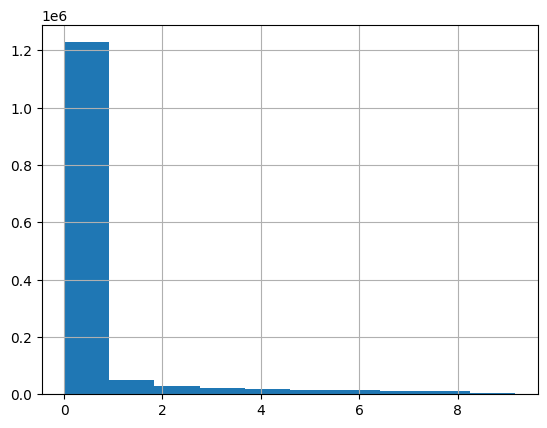

In [8]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.005].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [9]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:07<00:00, 39.42it/s]


In [10]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8070


event   tolerance
onset   12           0.397813
        36           0.726030
        60           0.793975
        90           0.830624
        120          0.856376
        150          0.867943
        180          0.879413
        240          0.890385
        300          0.895995
        360          0.902415
wakeup  12           0.442140
        36           0.727574
        60           0.800473
        90           0.830551
        120          0.854235
        150          0.864141
        180          0.876561
        240          0.890819
        300          0.902634
        360          0.910471
dtype: float64

In [11]:
%cp -r logs {CFG["output_dir"]}